# Data Analysis Interview Challenge
This is your chance to wow us with creative and rigorous solutions! Please include your code at
the end of your submission, or in a separate file. We also accept incomplete solutions.

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [572]:
#### Load Packages here
import os
import pandas as pd
import datetime as dt
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from datetime import date, timedelta
%matplotlib inline

In [573]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

 First load in the `logins.json` data.

In [574]:
## Laod logins.json
df = pd.read_json((r"C:\Users\micha\Documents\Springboard\Ultimate-Tech\ultimate_challenge\logins.json"))

Take a quick peek.

In [575]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [576]:
df.shape

(93142, 1)

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [578]:
print('Looks like a dataframe of ', df.shape[0],  ' login times from long, long ago.')

Looks like a dataframe of  93142  login times from long, long ago.


First lets's take a peek at daily counts.

<Axes: xlabel='login_time'>

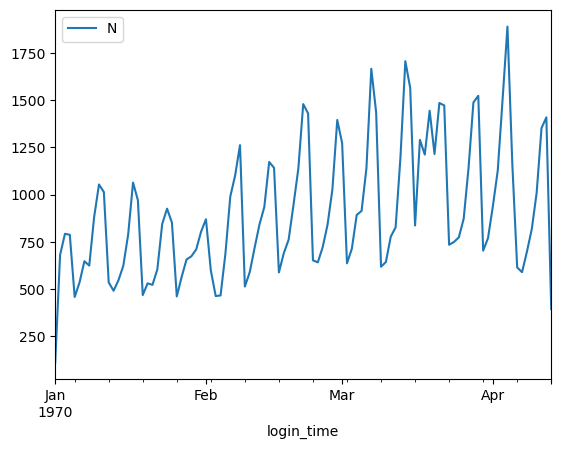

In [579]:
#Group by day and count
df['N'] = 1
df = df.set_index('login_time')
df_day = df.resample('D').count()
df_day.plot()

There is pretty clear weekly variaion.

In [580]:
df_weekly = pd.DataFrame()


for i, row in df_day.iloc[4:,:].iterrows():  # 4 is to skip to first Monday
    day = i.weekday()
    if day == 0:
        index = i
    df_weekly.loc[index, day] = row['N']
    
df_weekly.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekly.dropna(axis=0, inplace=True)

In [581]:
df_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
1970-01-05,459.0,536.0,648.0,625.0,881.0,1054.0,1014.0
1970-01-12,536.0,492.0,547.0,624.0,789.0,1064.0,971.0
1970-01-19,469.0,531.0,523.0,605.0,845.0,926.0,852.0
1970-01-26,462.0,565.0,657.0,674.0,711.0,805.0,870.0
1970-02-02,599.0,464.0,467.0,688.0,990.0,1102.0,1262.0
1970-02-09,514.0,590.0,719.0,842.0,935.0,1173.0,1142.0
1970-02-16,589.0,690.0,762.0,946.0,1139.0,1479.0,1430.0
1970-02-23,653.0,642.0,722.0,841.0,1028.0,1395.0,1273.0
1970-03-02,637.0,714.0,893.0,914.0,1140.0,1666.0,1434.0
1970-03-09,619.0,644.0,778.0,827.0,1199.0,1706.0,1565.0


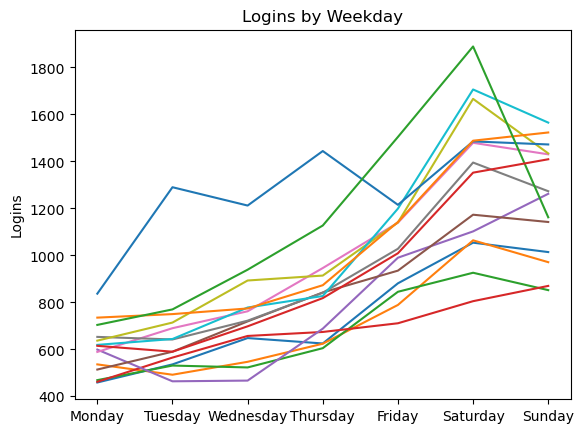

In [582]:
#Plot all weeks
for i, row in df_weekly.iterrows():
    plt.plot(df_weekly.columns, row)

plt.title("Logins by Weekday")
plt.ylabel("Logins")
plt.show()

In [583]:
df15 = df.resample('15T').count()

In [584]:
df_15 = pd.DataFrame()


for i, row in df15.iloc[16:,:].iterrows():    ## 16 is to skip newyears day
    time = i.strftime('%H:%M')
    if (i.hour == 0) & (i.minute == 0):
        index = i
    df_15.loc[index, time] = row['N']

df_15.dropna(axis=0, inplace=True)
df_15.head()

,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,02:15,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1970-01-02,10.0,18.0,12.0,13.0,9.0,8.0,10.0,6.0,7.0,18.0,...,11.0,14.0,15.0,18.0,21.0,17.0,12.0,12.0,12.0,15.0
1970-01-03,5.0,10.0,7.0,17.0,13.0,13.0,17.0,11.0,22.0,21.0,...,6.0,10.0,12.0,15.0,19.0,17.0,13.0,17.0,12.0,15.0
1970-01-04,11.0,14.0,15.0,12.0,7.0,15.0,29.0,25.0,21.0,32.0,...,4.0,6.0,9.0,4.0,6.0,7.0,2.0,7.0,5.0,6.0
1970-01-05,8.0,3.0,7.0,4.0,7.0,5.0,7.0,5.0,5.0,1.0,...,6.0,4.0,4.0,8.0,3.0,10.0,7.0,6.0,7.0,5.0
1970-01-06,7.0,4.0,7.0,7.0,8.0,5.0,5.0,4.0,4.0,5.0,...,8.0,23.0,24.0,19.0,11.0,12.0,9.0,7.0,7.0,8.0


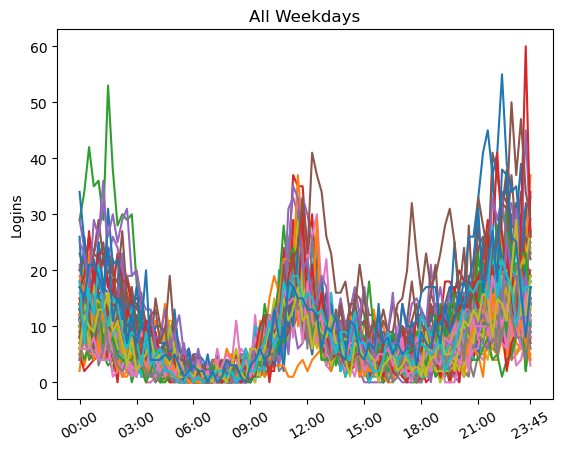

In [585]:
#Plot all weekdays
for i, row in df_15.iterrows():
    if i.weekday() != 5 and i.weekday() != 6:
        plt.plot(df_15.columns, row)

plt.title('All Weekdays')
plt.ylabel('Logins') 
k = 12
ys = df_15.columns[::k]
ys = np.append(ys, df_15.columns[-1])
plt.xticks(ys, rotation=30)
plt.show()

On weekdays the typical pattern is a peak around 11 PM slowly dropping off throughout the night until a low point around 6 AM there is a shorter spike in logins starting around 9 AM peaking at about Noon and dropping to a slightly higher low point ythan in the morning, before steadily climbing back to the next peak at 11 PM.

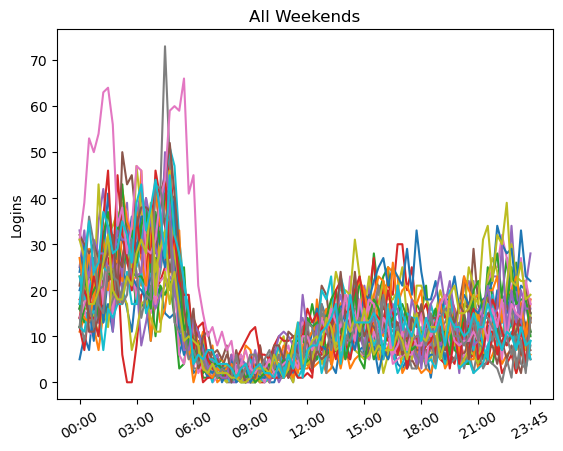

In [586]:
#Plot all weekdays
for i, row in df_15.iterrows():
    if i.weekday() == 5 or i.weekday() == 6:
        plt.plot(df_15.columns, row)

plt.title('All Weekends')
plt.ylabel('Logins')
k = 12
ys = df_15.columns[::k]
ys = np.append(ys, df_15.columns[-1])
plt.xticks(ys, rotation=30)
plt.show()

On weekends the daily cycle starts very high in the late night hours then drops sharply around 6 AM and climbs throughout the day and into the night.

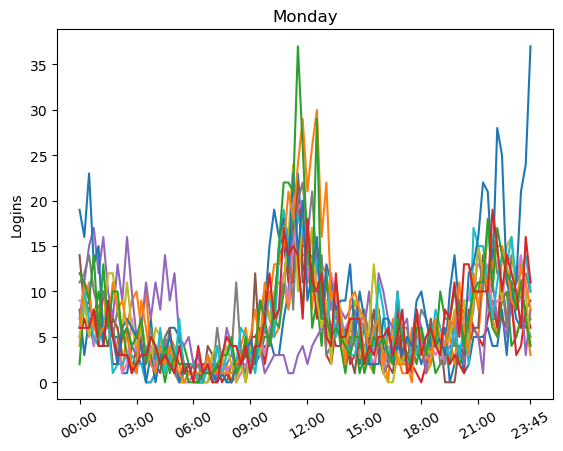

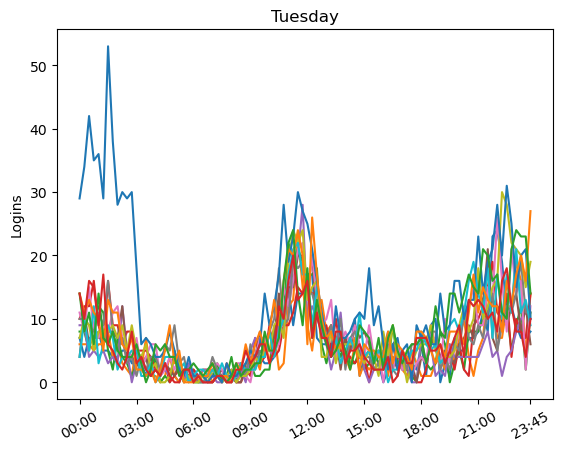

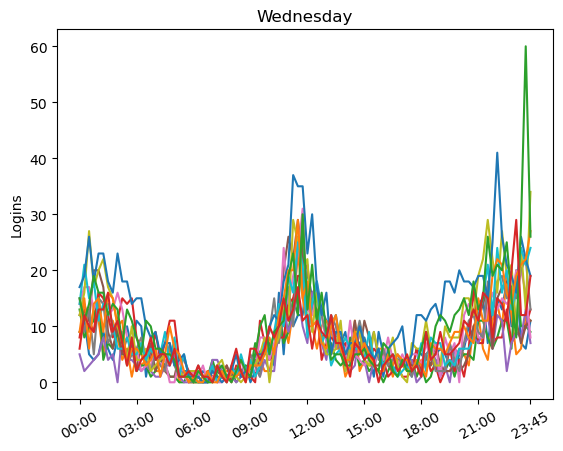

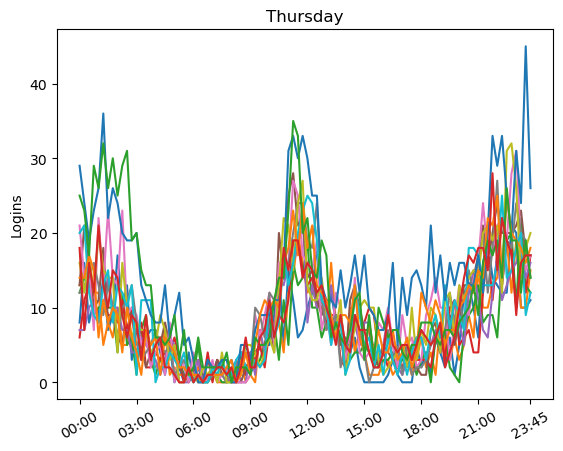

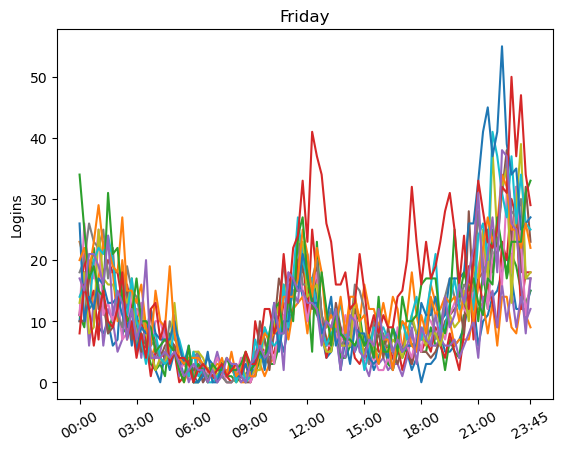

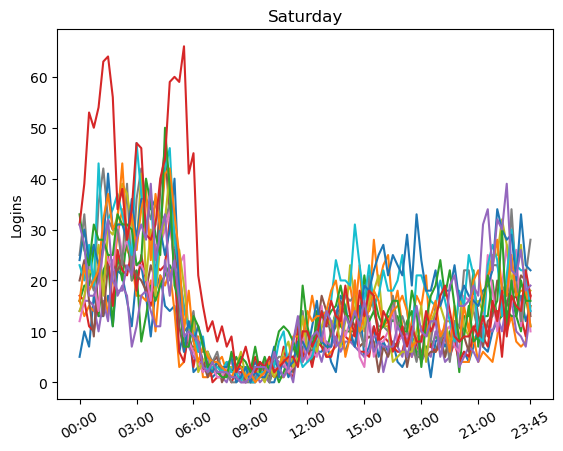

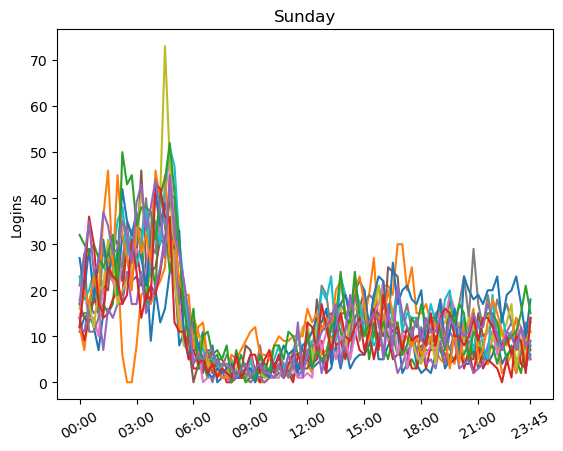

In [587]:
#Plot all days of week
titles =  ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in range(0,7):
    for i, row in df_15.iterrows():
  
        if i.weekday() == day:
            plt.plot(df_15.columns, row)
    plt.title(titles[day])
    plt.ylabel("Logins")
    k = 12
    ys = df_15.columns[::k]
    ys = np.append(ys, df_15.columns[-1])
    plt.xticks(ys, rotation=30)
    plt.show()

### Summmarize part 1 here

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? ###

Since the goal is to increase driver availability the best metric would be the proportion of 'non-home city' dropoffs and pickups. Some other metrics have potential such as counting toll crossings or looking at wait times or period of 'unavailability' but have some issues in answering this particular question. The complementary circadian cycle in each city decreases the impact of counting toll crossings, since drivers might stay in the more lucrertive location and not actually return to their 'home' city that often. Presumably if the toll crossings went up this would indict success but the plan might be successful even without toll crossings going up due to the opposing activity times in the two cities. The number of toll crossings would certainly be important, particularly in evaluating the costs of the program, but not for determining whether or not driver availability has gone up. Another potential measure of availability might be looking at passenger waittimes as increased availability should be seen in lower waittimes. Similarly, the length of time when rides are not available in a particular city would be expected to drop if there were greater availability. The problem with this type of metric is that these could both be due to other changes such as an increase in drivers or changes to demand and would not determine if the cause was the toll reimbursement. The proportion of riders picked up or dropped off in the driver's 'non-home' city would be the best metric for this problem. It would be relatively easy to collect and the 'home' city is easily assigned. It would not be succeptible to either of the problems above as a driver who stays in the non-home city with increase the proportion of non-home city riders irrespective of the number of bridge crossings. The external factors such as more driver or changes in demand would likely not affect the proportion in a particularly strong way unless the external factors struck the two cities very differently.


### 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
 **a) How you will implement the experiment?**
 
 Using the metric of the proportion of dropoffs and pickups in the 'non-home' city a hypothesis test can be set up. First, a control period should be chosen. It should be recent and as long as possible with general conditions of driver availablity not  significantly different from the current conditions. Each driver's pickups and dropoffs are totaled and the driver's home city is assigned to be the one with the majority (pick on randomly for ties), with this assignment the proportion of 'non-home city' dropoffs and pickups is computed for the control period. Set the test period long enough to account for seasonality(if possible) and get another sample of proportions for the drivers during the test period. The confindence level of the test is dependent on the total number of pickups and dropoffs in each sample so the more the better.      


 **b) What statistical test(s) you will conduct to verify the significance of the observation**
 
 I would then set up a hypothesis test with the null hypothesis that the control and test proportions are the same and the alternate hypothesis is that the proportion is higher in the test group. Then run a Z-test for proportions (it seems highly unlikely there would be insufficient data for this test even if the proportion is highly skewed) or a direct computation of the p-value could be computed with a binomial distribution(although this could be computationally expensive). Either way a small p-value would indicate a high level of confidence that the proportion has increased and the 'availability' has also increased.

 **c) How you would interpret the results and provide recommendations to the city operations team along with any caveats.**
 
 I would then look at the actual result from the test and based on the cities' desired confidence level interpret the test as either having confidence that the 'availaility' has increased or not. The caveats would be that the data was accurately representing current and past levels of 'availability' and that no confounding variables are present which might obscure the cause of a change or lack of change in 'availability'. 
 





## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **I will use the final data collection date as "today" to determine active athough this is obviously not actually today**

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.



**2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.**

**3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice)**

### Data description
 `city`: city this user signed up in

 `phone`: primary device for this user

 `signup_date`: date of account registration; in the form ‘YYYYMMDD’

  `last_trip_date`: the last time this user completed a trip; in the form ‘YYYYMMDD’

  `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup

  `avg_rating_by_driver`: the rider’s average rating over all of their trips

  `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips

  `surge_pct`: the percent of trips taken with surge multiplier > 1

  `avg_surge`: The average surge multiplier over all of this user’s trips

  `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up

  `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

  `weekday_pct`: the percent of the user’s trips occurring during a weekday

**1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?**

Load the dataset `ultimate_data_challenge.json`

In [588]:
ultimate = pd.read_json((r"C:\Users\micha\Documents\Springboard\Ultimate-Tech\ultimate_challenge\ultimate_data_challenge.json"))
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [589]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are only three columns with missing values `avg_rating_of_driver` , `phone`, and `avg_rating_by_driver`

In [590]:
# convert to datetime and find last date of data collection
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)
final_date = sorted(ultimate.last_trip_date)[-1]
retention_date = final_date - timedelta(days=30)
print('The final date is ', final_date.strftime('%Y-%m-%d'), ' so the date for retention purposes is  ', retention_date.strftime('%Y-%m-%d'))

The final date is  2014-07-01  so the date for retention purposes is   2014-06-01


Now the target column of `retained` can be added '1' if they had a ride after the retention date (so they must have taken a ride in June 2014)

In [591]:
#Add retained column
ultimate["retained"] = ultimate.apply(lambda row: 1 if row['last_trip_date'] > retention_date else 0, axis=1)
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


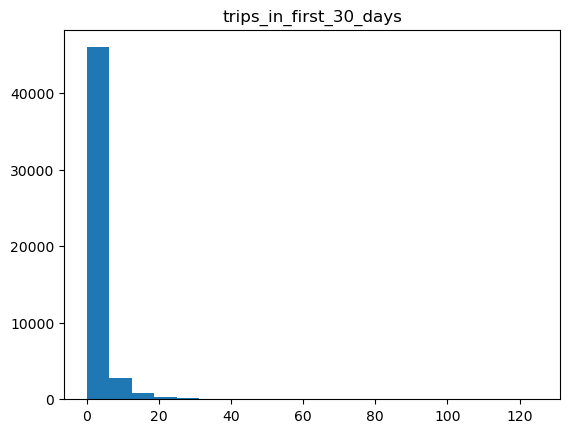

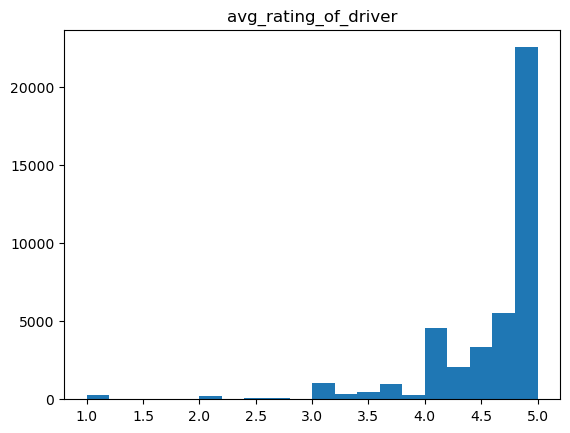

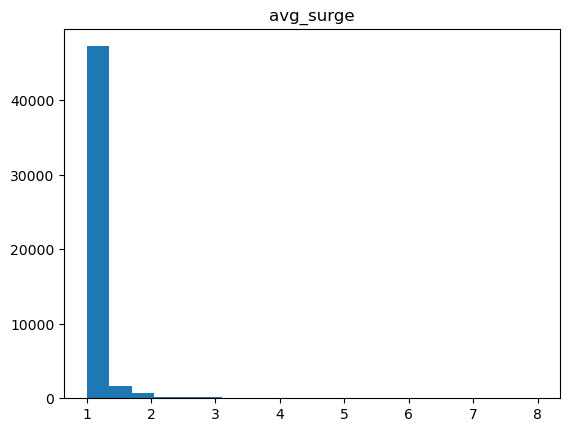

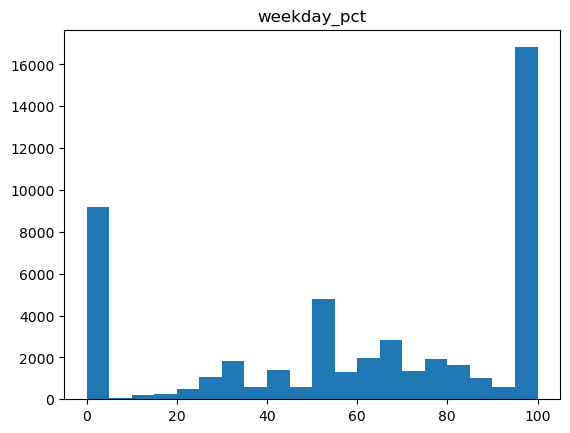

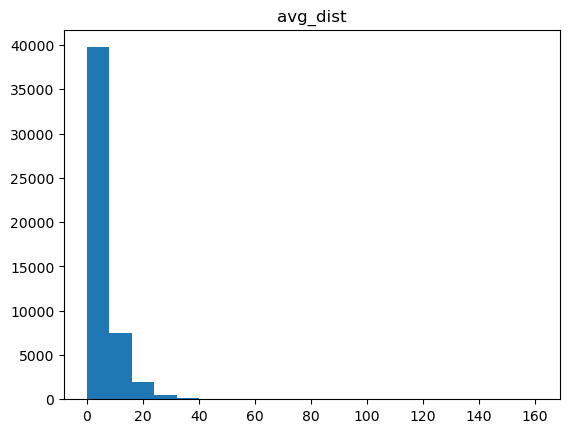

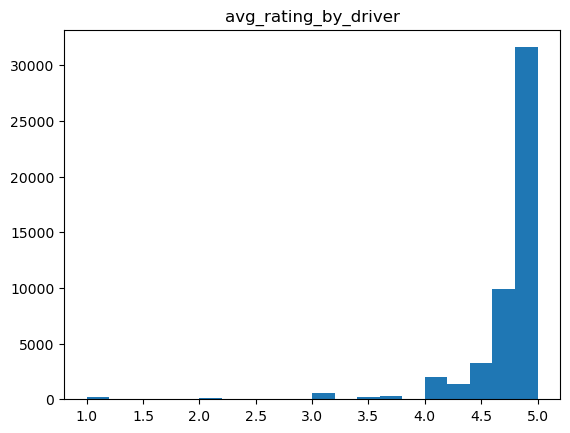

In [592]:
numeric_col = ['trips_in_first_30_days', 'avg_rating_of_driver','avg_surge', 'weekday_pct', 'avg_dist','avg_rating_by_driver' ]

#plt.subplots(2,3)
for col in numeric_col:
    plt.hist(ultimate[col], bins=20)
    plt.title(col)
    plt.show()

In [593]:
numeric_col.append('retained')
ult_numeric = ultimate[numeric_col]
ult_numeric.head()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,4,4.7,1.10,46.2,3.67,5.0,1
1,0,5.0,1.00,50.0,8.26,5.0,0
2,3,4.3,1.00,100.0,0.77,5.0,0
3,9,4.6,1.14,80.0,2.36,4.9,1
4,14,4.4,1.19,82.4,3.13,4.9,0


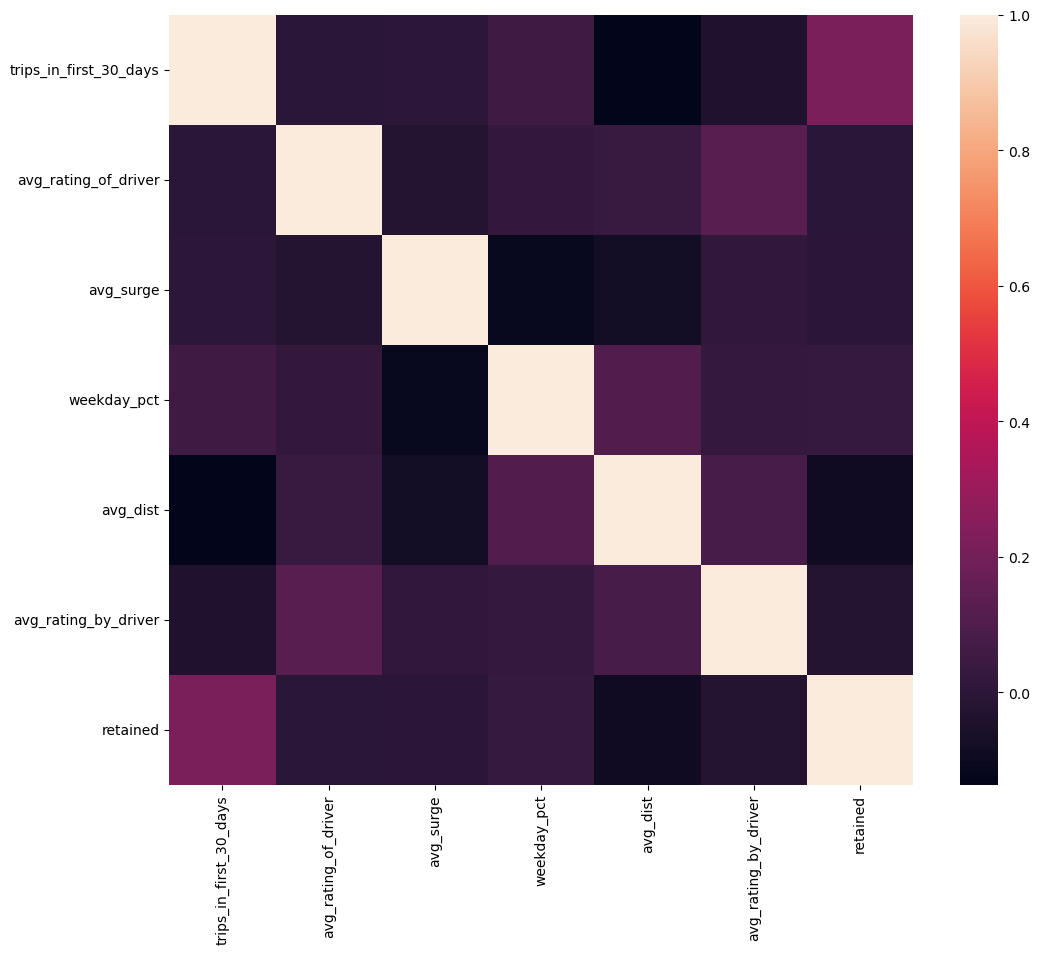

In [594]:
plt.subplots(figsize=(12,10))
sns.heatmap(ult_numeric.corr());

There does not seem to be much correlation at this point between variables it remains to investigate the target `retention`.


In [595]:
## overall retention
print("Percentage retained(overall): {:.2f}%".format(ultimate.retained.sum() / len(ultimate) * 100))


Percentage retained(overall): 36.62%


In [596]:
city = ultimate.groupby('city').agg({'retained':'sum','phone':'count'}, axis=0)
city.groupby(level=0).apply(lambda x: 100 * x.retained / x.phone)

city            city          
Astapor         Astapor           24.504966
King's Landing  King's Landing    62.656467
Winterfell      Winterfell        34.512432
dtype: float64

At this point the data is cleaned and ready to go. I left the imputaion of the NaN values for the preprocessing. I did not want to dig into the data to far but it certainly seems like King's Landing has much great retention. Later I will look more deeply at features which have hig importance in the chosen model. 



**2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.**

In [597]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [598]:
# Split the data
X = ultimate.drop('retained',axis=1)
y = ultimate['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=714)

In [599]:
# pick transformers
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [600]:
# split columns into numeric and categorical
numeric_features = ['trips_in_first_30_days', 'avg_rating_of_driver','avg_surge', 'weekday_pct', 'avg_dist','avg_rating_by_driver']
categorical_features = ['city', 'phone','ultimate_black_user']
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

### Logistic Regression

In [601]:
# define the pipeline
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',LogisticRegression())
           ])

In [602]:
lr_model = pipeline.fit(X_train, y_train)
print (lr_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trips_in_first_30_days',
                                                   'avg_rating_of_driver',
                                                   'avg_surge', 'weekday_pct',
                                                   'avg_dist',
                                                   'avg_rating_by_driver']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                

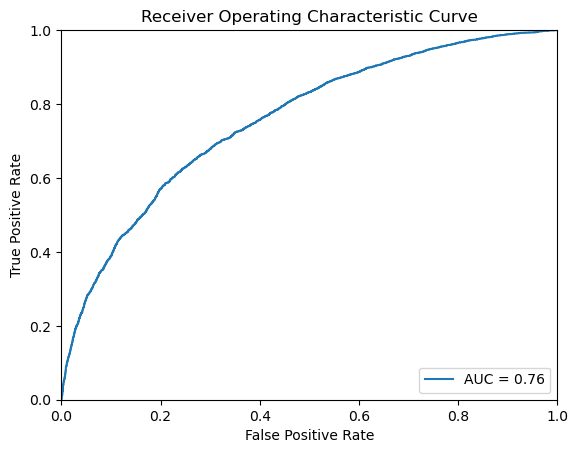

In [603]:
#ROC CURVES and AUC 
# plot ROC curve function
def plot_roc_curve(X_test, y_test, pipeline):
    probs = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs) 
    roc_auc = metrics.roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label= 'AUC = %0.2f' % roc_auc) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic Curve')
    plt.show()
plot_roc_curve(X_test, y_test, pipeline)

In [604]:
# calculate AUC 
print("Percentage ROC-AOC: {:.2f}%".format(metrics.roc_auc_score(y_test, probs)*100))

Percentage ROC-AOC: 75.69%


In [605]:
## define a n fold cross validation function
def cv_function(model,X_train, X_test, y_train, y_test, n=4):
    cv_scores_test= cross_val_score(model,X_test,y_test,cv=4,scoring='roc_auc')
    cv_scores_train= cross_val_score(model,X_train,y_train,cv=4,scoring='roc_auc')
    print(cv_scores_test)
    global cv_scores_m_test
    cv_scores_m_test= cv_scores_test.mean()
    global cv_precision_m_test 
    cv_precision_m_test = cross_val_score(model,X_test,y_test,cv=4,scoring='precision').mean()
    global cv_recall_m_test 
    cv_recall_m_test = cross_val_score(model,X_test,y_test,cv=4,scoring='recall').mean()
    cv_scores_m_train= cv_scores_train.mean()
    cv_scores_m_std = cv_scores_test.std()
    print ('Mean cross validation test score: ' +str(cv_scores_m_test))
    print ('Mean cross validation train score: ' +str(cv_scores_m_train))
    print ('Standard deviation in cv test scores: ' +str(cv_scores_m_std))
    return cv_scores_m_test, cv_precision_m_test, cv_recall_m_test 
cv_function(lr_model,X_train, X_test, y_train, y_test)

[0.75131065 0.74973535 0.75171896 0.77388162]
Mean cross validation test score: 0.7566616452995918
Mean cross validation train score: 0.7702251164861156
Standard deviation in cv test scores: 0.009969510097241115


(0.7566616452995918, 0.6568695572182947, 0.4707958478712743)

In [606]:
table = pd.DataFrame([['Logistic Regression', cv_recall_m_test, cv_precision_m_test, cv_scores_m_test]] , columns = ['Model','Recall','Precision','ROC-AOC'])
table

,Model,Recall,Precision,ROC-AOC
0,Logistic Regression,0.470796,0.65687,0.756662


Looks pretty good not much in the way of overfitting certainly worth fine tuning with a grid search. Next up.

### Random Forest

In [607]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', RandomForestClassifier(bootstrap=True,n_estimators=40,criterion='entropy', max_depth=4,random_state=714))
           ])
rf = pipeline.fit(X_train, y_train)


#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)


[[5684  601]
 [1775 1940]]
0.7624


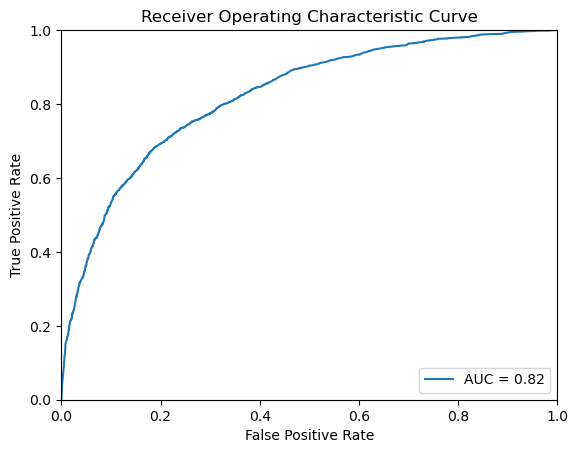

In [608]:
plot_roc_curve(X_test, y_test, pipeline)

In [609]:
cv_function(rf,X_train, X_test, y_train, y_test)

[0.81266075 0.82718391 0.81680095 0.84410867]
Mean cross validation test score: 0.8251885700215269
Mean cross validation train score: 0.8331315676632596
Standard deviation in cv test scores: 0.0121372379050315


(0.8251885700215269, 0.7598712254901794, 0.5224837376118184)

In [610]:
j=1
table.loc[j] = ['Random Forest', cv_recall_m_test, cv_precision_m_test , cv_scores_m_test]
print(table)
j+=1

                 Model    Recall  Precision   ROC-AOC
0  Logistic Regression  0.470796   0.656870  0.756662
1        Random Forest  0.522484   0.759871  0.825189


Turns out even better. 

### Gradient Boosting

In [611]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GradientBoostingClassifier(subsample=0.8, learning_rate=0.01 , n_estimators=100, max_depth=4, max_leaf_nodes=30,random_state=714))
           ])
gbc = pipeline.fit(X_train, y_train)

#Predict using the model:

y_predict_gbc = gbc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)
Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

[[5774  511]
 [1849 1866]]
0.764


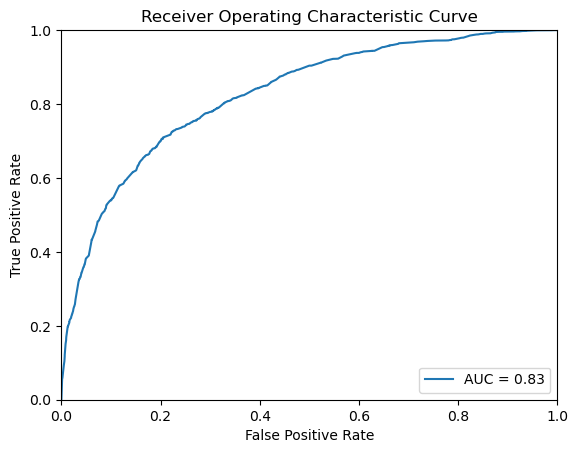

In [612]:
plot_roc_curve(X_test, y_test, pipeline)

In [613]:
cv_function(gbc,X_train, X_test, y_train, y_test)

[0.81062245 0.82660801 0.82455862 0.84342486]
Mean cross validation test score: 0.826303484756225
Mean cross validation train score: 0.8363227061601708
Standard deviation in cv test scores: 0.01164231037525198


(0.826303484756225, 0.7739042528782141, 0.5243660336476004)

In [614]:
table.loc[j] = ['Gradient Boosting', cv_recall_m_test, cv_precision_m_test , cv_scores_m_test]
print(table)
j+=1

                 Model    Recall  Precision   ROC-AOC
0  Logistic Regression  0.470796   0.656870  0.756662
1        Random Forest  0.522484   0.759871  0.825189
2    Gradient Boosting  0.524366   0.773904  0.826303


### Support Vector Machine

Ran too slow

### KNN

In [615]:
### KNN
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', KNeighborsClassifier(p=2,weights='distance',n_neighbors=6))
           ])

knn = pipeline.fit(X_train,y_train)

y_predict_knn = pipeline.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)

[[5080 1205]
 [1436 2279]]


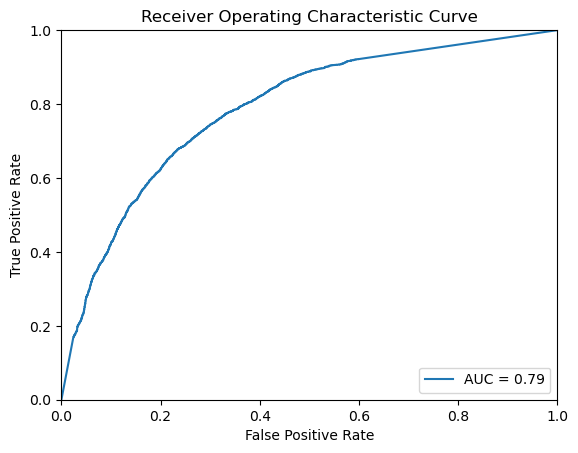

In [616]:
plot_roc_curve(X_test, y_test, pipeline)

In [617]:
cv_function(knn ,X_train, X_test, y_train, y_test)

[0.76598214 0.76835595 0.75855711 0.78796629]
Mean cross validation test score: 0.770215372017189
Mean cross validation train score: 0.7941062367303706
Standard deviation in cv test scores: 0.01086724511330591


(0.770215372017189, 0.6322231779332133, 0.5916563045172785)

In [618]:
table.loc[j] = ['KNN', cv_recall_m_test, cv_precision_m_test , cv_scores_m_test]
print(table)
j+=1

                 Model    Recall  Precision   ROC-AOC
0  Logistic Regression  0.470796   0.656870  0.756662
1        Random Forest  0.522484   0.759871  0.825189
2    Gradient Boosting  0.524366   0.773904  0.826303
3                  KNN  0.591656   0.632223  0.770215


### Model choice

I chose the random forest model based on performance and ease of use. The benefits over faster models like Linear Regression are easily seen in the table. 

In [503]:
# Grid Search for Random Forest
param_grid = { 'max_depth': [4, 5, 6, 8, None],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [40, 80, 100, 200, 400, 1000],
 'max_features': [None, "sqrt", "log2"]}

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(RandomForestClassifier(random_state=42), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

C:\ProgramData\Anaconda3\envs\snakes\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2400 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
980 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\snakes\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\snakes\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\Anaconda3\envs\snakes\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints

0.8455588783565733

In [505]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

RandomForestClassifier(min_samples_leaf=8, n_estimators=1000, random_state=42)
0.8533344393120088


In [506]:
param_grid = {'n_estimators': [500,1000],
              'max_features':[None, 4],
              'min_samples_leaf': [8]}

In [507]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(RandomForestClassifier(random_state=42), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

RandomForestClassifier(max_features=4, min_samples_leaf=8, n_estimators=1000,
                       random_state=42)
0.85331692612356


In [508]:
param_grid = {'n_estimators': [1000],
              'max_features':[ 4,5,8],
              'min_samples_leaf': [8],
              'criterion': ['gini','entropy'],
              'class_weight': ['balanced', 'balanced_subsample', None]}

In [509]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(RandomForestClassifier(random_state=714), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

RandomForestClassifier(criterion='entropy', max_features=4, min_samples_leaf=8,
                       n_estimators=1000, random_state=714)
0.8533809806633323



### Grid Search
A grid search was done to find the best parameters although there was not really all that much difference. 
The parameters were:

RandomForestClassifier(criterion='entropy', max_features=4, min_samples_leaf=8,
                       n_estimators=1000, random_state=714)
Then run the Random forest model with the above parameters.

In [530]:
# AOC scoring 
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', RandomForestClassifier(criterion='entropy', max_features=4, min_samples_leaf=8,n_estimators=1000, random_state=714))
           ])
rf = pipeline.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cv_scores_rf_test = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
cv_scores_std_rf = cross_val_score(rf, X_test, y_test, scoring='roc_auc').std()
cv_recall_rf = cross_val_score(rf, X_test, y_test,scoring='recall').mean()
print("Accuracy: ", acc)
cv_rf = cross_val_score(rf, X_test, y_test,scoring='roc_auc')
print("Recall: ", cv_recall_rf)
print("ROC-AUC", cv_scores_rf_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Accuracy:  0.7817
Recall:  0.6209959623149394
ROC-AUC 0.8388841598756251
Confusion Matrix:
[[5470  815]
 [1368 2347]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6285
           1       0.74      0.63      0.68      3715

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



In [534]:
#Precision Recall Curve and AUC 
# plot ROC curve function
def plot_precision_recall_curve(X_test, y_test, pipeline):
    probs = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
    plt.title("Precision Recall Curve")
    prc_auc = metrics.auc(recall, precision)
    plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
    plt.legend(loc = 'lower left')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0]) 
    plt.xlabel('Recall') 
    plt.ylabel('Precision') 
    plt.show()

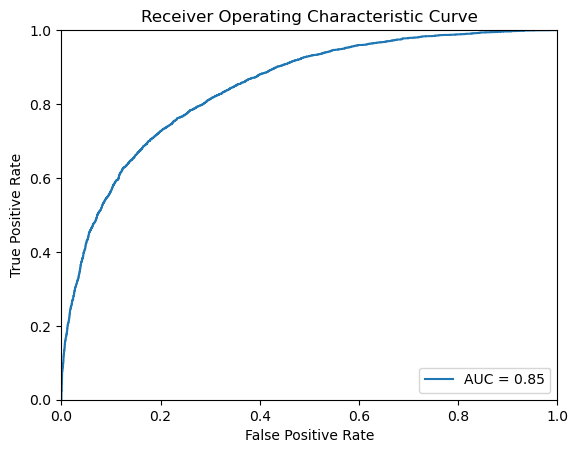

In [535]:
plot_roc_curve(X_test, y_test, pipeline)

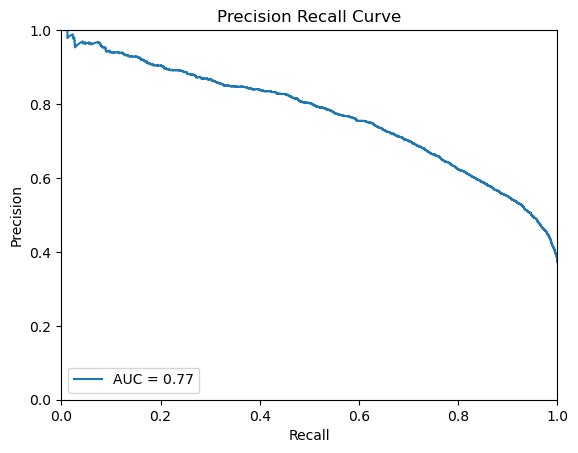

In [536]:
plot_precision_recall_curve(X_test, y_test, pipeline)

numeric__avg_rating_by_driver             0.173612
numeric__weekday_pct                      0.147457
numeric__avg_dist                         0.132678
numeric__avg_surge                        0.119045
categorical__city_King's Landing          0.102735
numeric__trips_in_first_30_days           0.076397
numeric__avg_rating_of_driver             0.053500
categorical__phone_Android                0.044247
categorical__phone_iPhone                 0.038690
categorical__ultimate_black_user_False    0.033709
categorical__ultimate_black_user_True     0.032319
categorical__city_Astapor                 0.026483
categorical__city_Winterfell              0.018709
categorical__phone_None                   0.000420
dtype: float64


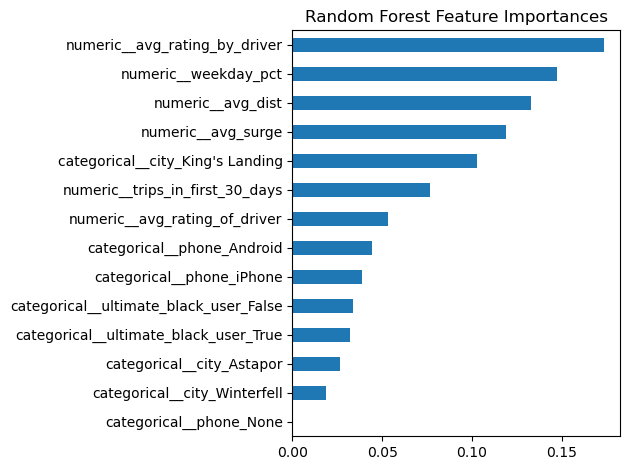

In [555]:
## Make this a function
feature_names = rf[:-1].get_feature_names_out()
model_feature_importances = pd.Series(rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)
print(model_feature_importances.sort_values(ascending=False))
ax = model_feature_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

In [557]:
ultimate[ultimate['trips_in_first_30_days'] == 1].groupby('retained')['avg_rating_by_driver'].mean()

retained
0    4.791874
1    4.776053
Name: avg_rating_by_driver, dtype: float64

In [558]:
ultimate[ultimate['trips_in_first_30_days'] > 1].groupby('retained')['avg_rating_by_driver'].mean()

retained
0    4.779026
1    4.742618
Name: avg_rating_by_driver, dtype: float64

In [559]:
ultimate[ultimate['trips_in_first_30_days'] == 1].groupby('retained')['retained'].count()

retained
0    11065
1     3043
Name: retained, dtype: int64

In [561]:
ultimate[ultimate['trips_in_first_30_days'] == 2 ].groupby('retained')['retained'].count()

retained
0    4728
1    2674
Name: retained, dtype: int64

In [562]:
ultimate[ultimate['trips_in_first_30_days'] == 0 ].groupby('retained')['retained'].count()

retained
0    10048
1     5342
Name: retained, dtype: int64

In [563]:
ultimate[ultimate['trips_in_first_30_days'] < 1].groupby('retained')['avg_rating_by_driver'].mean()

retained
0    4.789702
1    4.794015
Name: avg_rating_by_driver, dtype: float64

Not retained mean: 4.7868762490879675
Retained mean: 4.763121033048807
Not retained mean: 60.18159671820763
Retained mean: 62.21460404150738
Not retained mean: 6.1884777532344595
Retained mean: 5.11897706171491
Not retained mean: 1.0753666771852317
Retained mean: 1.0737203713817587


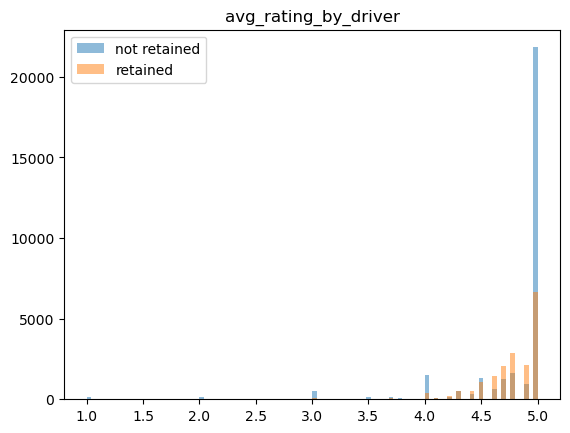

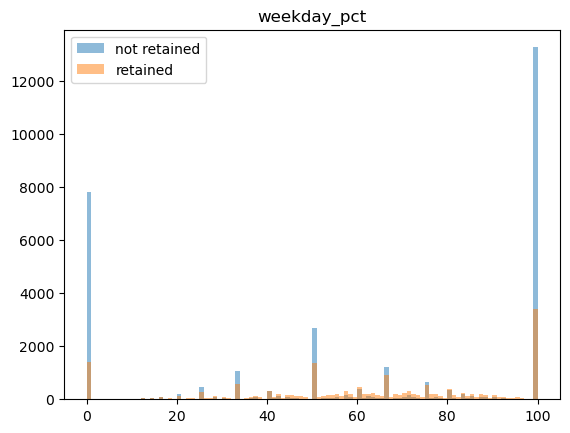

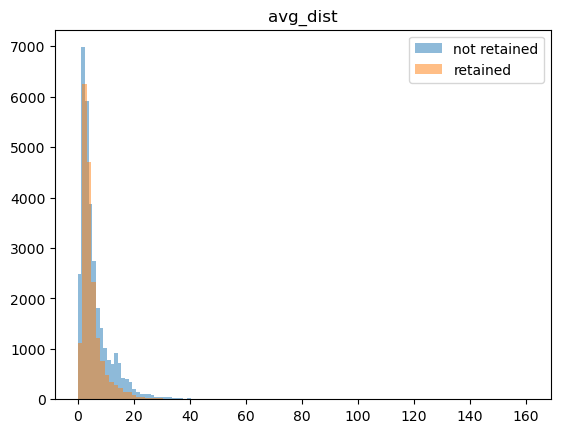

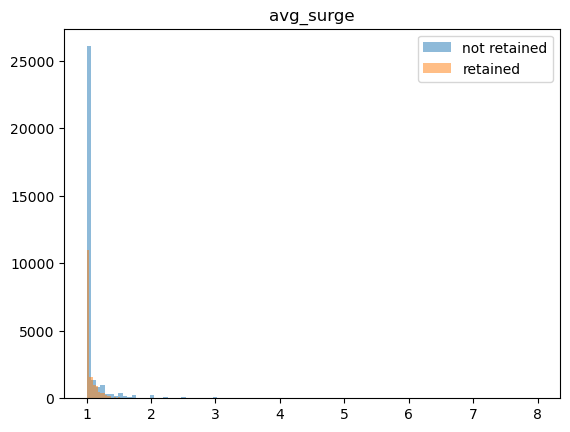

In [567]:
#Inspect Features
def inspect_features(df, feature_names, target):
    for col in feature_names:
        success = df.loc[df[target] == 1][col]
        fail = df.loc[df[target] == 0][col]
        plt.subplots()
        plt.hist(fail, bins = 100, alpha=0.5, label="not retained")
        plt.hist(success, bins = 100, alpha=0.5, label="retained")
        plt.legend()
        plt.title(col)
        plt.show
        print("Not retained mean: {}".format(fail.mean()))
        print("Retained mean: {}".format(success.mean()))
features = ['avg_rating_by_driver','weekday_pct', 'avg_dist','avg_surge']
inspect_features(ultimate,features,'retained')

**3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice)**

## Feature importance and recommendations

Some deeper analysis of the features and their importance is above.

It is clear the key thing to retention is getting people to take their second, third and fourth ride. The retention rate was actually higher for people taking no rides in the first 30 day than those taking exactly one ride. Since retained riders generally ride in surge periods and weekdays more than unretained riders perhaps some promotion after a first ride encouraging(e.g a discount) weekday or surge use. Similarly, a flat discount on the second ride will encourage a shorter ride which again may be linked to greater retention. Finally, there is the issue of King's Landing, whatever Ultimate is doing there continue it and try to emulate it in the other cities.